In [11]:
# ✅ Fix: Import train_test_split
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import pydicom
import io
from sklearn.model_selection import train_test_split  # <-- ADD THIS LINE

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("✅ Libraries imported & seeds set!")

✅ Libraries imported & seeds set!


In [12]:
# ✅ Add these imports to the top of your notebook
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.metrics import AUC

In [ ]:
# ✅ Load data with stratified split for class imbalance
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"

# Load CSV files
labels_df = pd.read_csv(os.path.join(dataset_path, "stage_2_train_labels.csv"))
class_df = pd.read_csv(os.path.join(dataset_path, "stage_2_detailed_class_info.csv"))

# Merge and deduplicate
merged = pd.merge(labels_df[['patientId','Target']], class_df[['patientId','class']], on='patientId')
merged = merged.drop_duplicates('patientId').reset_index(drop=True)

# Stratified split (80-20)
train_df, val_df = train_test_split(
    merged, 
    test_size=0.2, 
    stratify=merged['Target'], 
    random_state=SEED
)

print(f"Train: {len(train_df)} | Val: {len(val_df)}")
print("Pneumonia ratio:", train_df['Target'].mean())

Train: 21347 | Val: 5337
Pneumonia ratio: 0.22532440155525366


In [14]:
# ✅ Fix: Explicit shape definition at every step

# 1. Get file paths and labels (same as before)
train_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in train_df['patientId']]
train_labels = train_df['Target'].values.astype(np.int32)

val_paths = [os.path.join(dataset_path, "stage_2_train_images", pid + ".dcm") for pid in val_df['patientId']]
val_labels = val_df['Target'].values.astype(np.int32)

# 2. Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# 3. Preprocessing with enforced shapes
def process_path(path, label):
    # Read DICOM bytes
    img_bytes = tf.io.read_file(path)
    
    # Decode DICOM and enforce shape
    img = tf.numpy_function(
        lambda x: pydicom.dcmread(io.BytesIO(x)).pixel_array.astype(np.float32),
        [img_bytes],
        tf.float32
    )
    img.set_shape((1024, 1024))  # ⚠️ Critical fix: Set shape here
    
    # Normalize
    img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-7)
    
    # Add channel dim + convert to RGB
    img = tf.expand_dims(img, axis=-1)  # (1024, 1024, 1)
    img = tf.image.grayscale_to_rgb(img)  # (1024, 1024, 3)
    
    # Resize with known shape
    img = tf.image.resize(img, [224, 224])  # Now works
    
    # Augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.1)
    
    return img, label

# 4. Batch and prefetch
BATCH_SIZE = 32
train_ds = train_ds.map(process_path).shuffle(1000).batch(BATCH_SIZE).prefetch(2)
val_ds = val_ds.map(process_path).batch(BATCH_SIZE).prefetch(2)

In [15]:
# ✅ Handle class imbalance
class_counts = train_df['Target'].value_counts()
total = class_counts.sum()
class_weights = {
    0: total / (2 * class_counts[0]),  # Normal
    1: total / (2 * class_counts[1])   # Pneumonia
}
print("Class weights:", class_weights)

Class weights: {0: 0.6454314567333858, 1: 2.219022869022869}


In [16]:
# # ✅ DenseNet201 with regularization
# from tensorflow.keras import layers, models, applications

# # 1. Base model (first 150 layers frozen)
# base_model = applications.DenseNet201(
#     weights='imagenet', 
#     include_top=False, 
#     input_shape=(224, 224, 3)
# )
# for layer in base_model.layers[:150]:a
#     layer.trainable = False

# # 2. Custom head
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.5),  # Strong dropout
#     layers.Dense(64, activation='relu', kernel_regularizer='l2'),
#     layers.Dense(1, activation='sigmoid')
# ])

# # 3. Compile with AdamW
# model.compile(
#     optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
# )
# model.summary()

In [17]:
# Model Architecture Adjustments
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze first 200 layers
for layer in base_model.layers[:200]:
    layer.trainable = False

# Add SpatialDropout and stronger L2
model = Sequential([
    base_model,
    SpatialDropout2D(0.5),  # ⚠️ Critical fix
    GlobalAveragePooling2D(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Focal Loss for class imbalance
model.compile(
    optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss=BinaryFocalCrossentropy(gamma=2.0),  # Replace binary_crossentropy
    metrics=['accuracy', AUC(name='auc')]
)

In [18]:
# ✅ Prevent overfitting via early stopping and LR scheduling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_auc', 
        patience=5, 
        mode='max',  # Stop when AUC stops improving
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=2, 
        verbose=1
    )
]

# Calculate steps per epoch
steps_per_epoch = len(train_df) // BATCH_SIZE
val_steps = len(val_df) // BATCH_SIZE

# Train
history = model.fit(
    train_ds,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    class_weight=class_weights,  # Critical for imbalance
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 835s 785ms/step - accuracy: 0.6525 - auc: 0.7202 - loss: 1.0505 - val_accuracy: 0.8014 - val_auc: 0.8691 - val_loss: 0.4751 - learning_rate: 1.0000e-04
Epoch 2/30
  1/667 ━━━━━━━━━━━━━━━━━━━━ 42:40:05 231s/step - accuracy: 0.6667 - auc: 0.0000e+00 - loss: 0.4357

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


667/667 ━━━━━━━━━━━━━━━━━━━━ 296s 99ms/step - accuracy: 0.6667 - auc: 0.0000e+00 - loss: 0.4357 - val_accuracy: 0.8023 - val_auc: 0.8694 - val_loss: 0.4740 - learning_rate: 1.0000e-04
Epoch 3/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 359s 518ms/step - accuracy: 0.7543 - auc: 0.8453 - loss: 0.4401 - val_accuracy: 0.7690 - val_auc: 0.8751 - val_loss: 0.3398 - learning_rate: 1.0000e-04
Epoch 4/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 68s 102ms/step - accuracy: 0.3333 - auc: 0.0000e+00 - loss: 0.3687 - val_accuracy: 0.7693 - val_auc: 0.8751 - val_loss: 0.3401 - learning_rate: 1.0000e-04
Epoch 5/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 352s 507ms/step - accuracy: 0.7768 - auc: 0.8682 - loss: 0.3074 - val_accuracy: 0.8066 - val_auc: 0.8741 - val_loss: 0.2300 - learning_rate: 1.0000e-04
Epoch 6/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.2847 - val_accuracy: 0.8057 - val_auc: 0.8742 - val_loss: 0.2314 - learning_rate: 1.0000e-04
Epoch 7/30
667/667 ━━━━━━━━━━━━━━━━━━━━ 361s 5

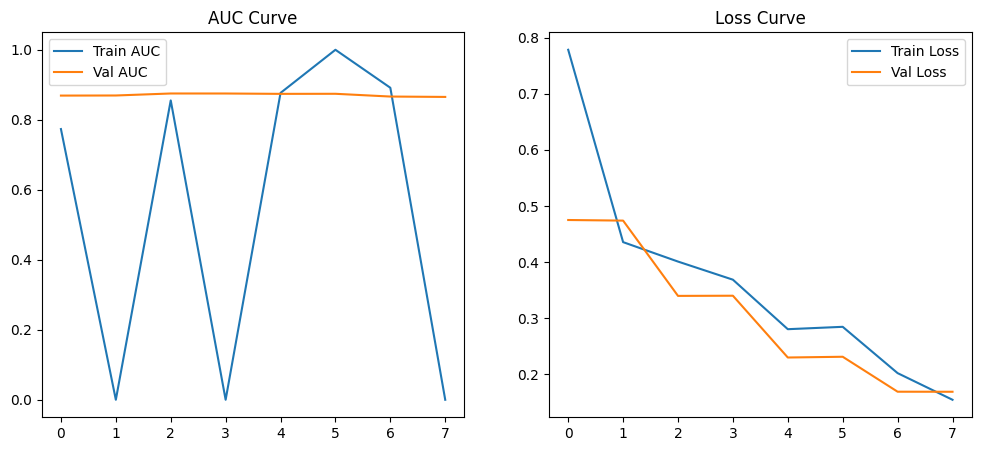

Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.75      0.83      4135
   Pneumonia       0.49      0.84      0.62      1202

    accuracy                           0.77      5337
   macro avg       0.72      0.79      0.73      5337
weighted avg       0.84      0.77      0.79      5337

ROC-AUC: 0.875249231933074


In [19]:
# ✅ Validate model performance on imbalanced data
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Generate predictions
y_true = []
y_pred = []
for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(model.predict(images, verbose=0).flatten())

# Classification report (focus on Pneumonia recall)
y_pred_class = (np.array(y_pred) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_true, y_pred_class, target_names=['Normal', 'Pneumonia']))

# ROC-AUC score
print("ROC-AUC:", roc_auc_score(y_true, y_pred))